In [141]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

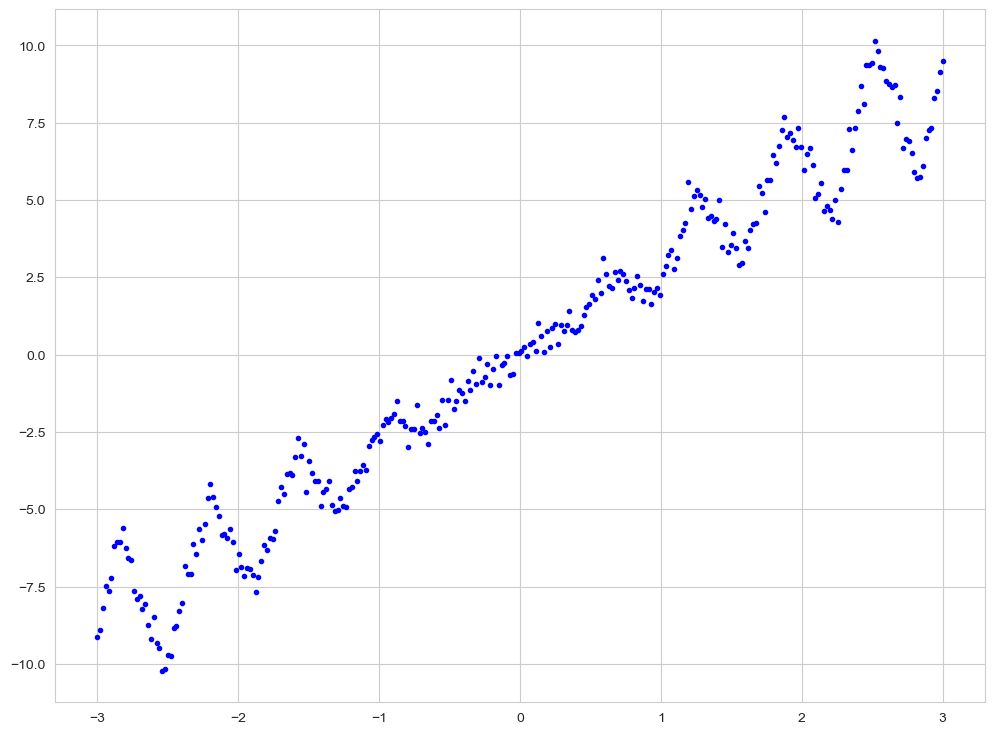

In [149]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [150]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(ylabel, fontsize=16, rotation=0)
    
    plt.scatter(X, y, s=0.5, color="slategray")
    plt.plot(x1, y_pred, linewidth=1.5, label=r"$\hat{y}$", color="indigo")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

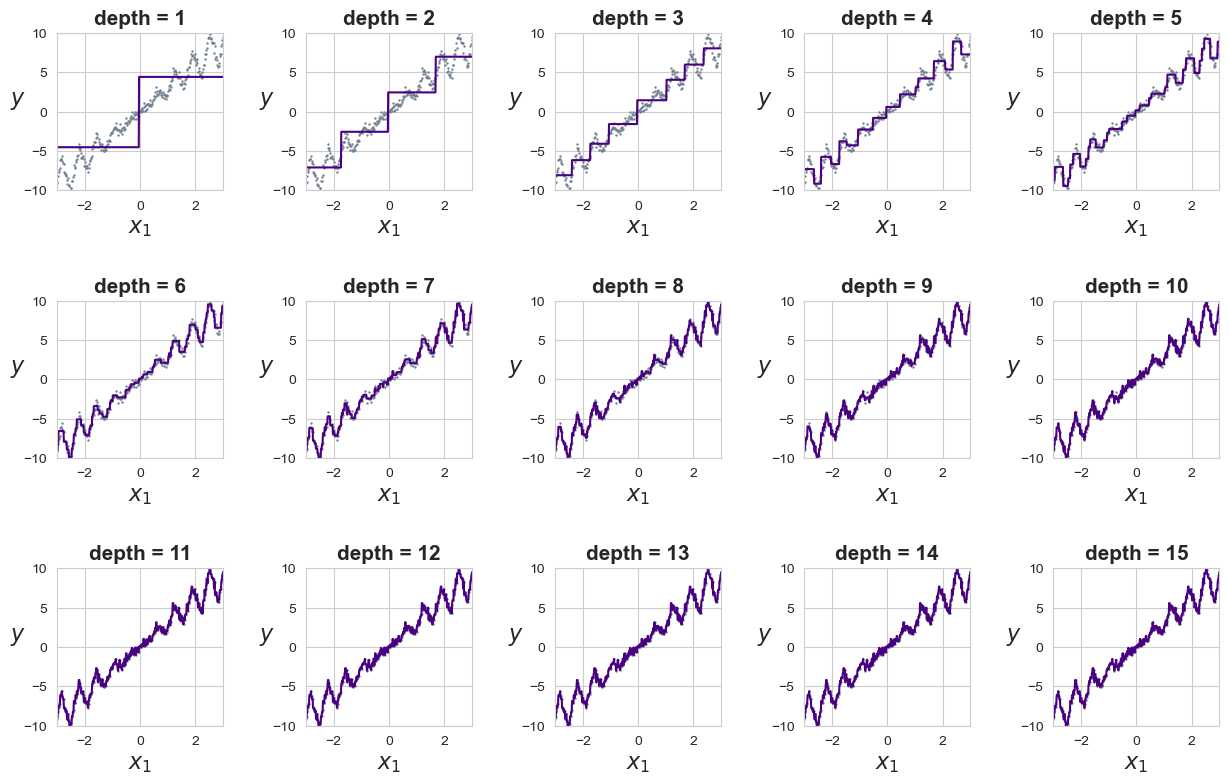

In [151]:
plt.figure(figsize=(15, 9))

for depth in range(1, 16):
    plt.subplot(3, 5, depth)
    plt.title(f'depth = {depth}', weight="bold", size=15)
    mdl = DecisionTreeRegressor(max_depth=depth)
    mdl.fit(X, y)
    plot_regression_predictions(mdl, X, y)
    plt.subplots_adjust(wspace=0.5, hspace=0.7)
    ;

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

''

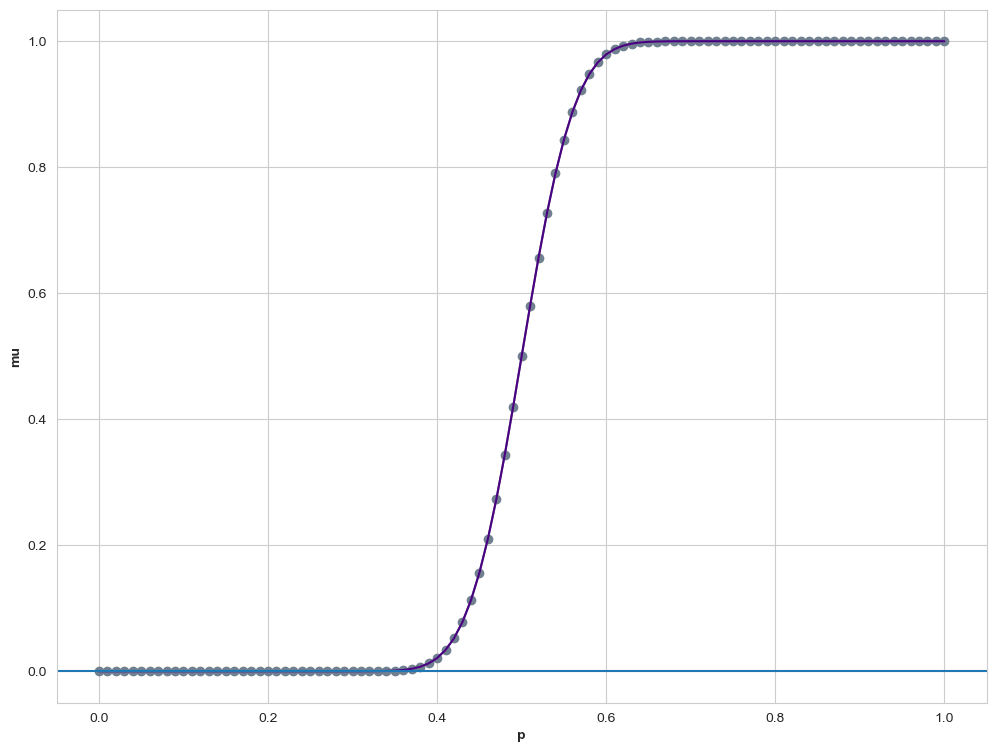

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

p = np.linspace(0, 1, 101)
m = 0
for i in np.arange(51, 102):
    m += (np.power((1 - p), (101 - i)) * np.power(p, i) * math.factorial(101)) / (math.factorial(i) * math.factorial(101 - i))

mp = pd.DataFrame({'p':p, 'm':m})
plt.subplot(111)
plt.plot(mp.p, mp.m, marker='o', color="slategray")
plt.plot(mp.p, mp.m, color="indigo")
plt.xlabel("p", weight='bold')
plt.ylabel("mu", weight='bold')
plt.axhline()
;

In [7]:
mp[mp.p == 0.6]

p         m
60  0.6  0.979103

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

''

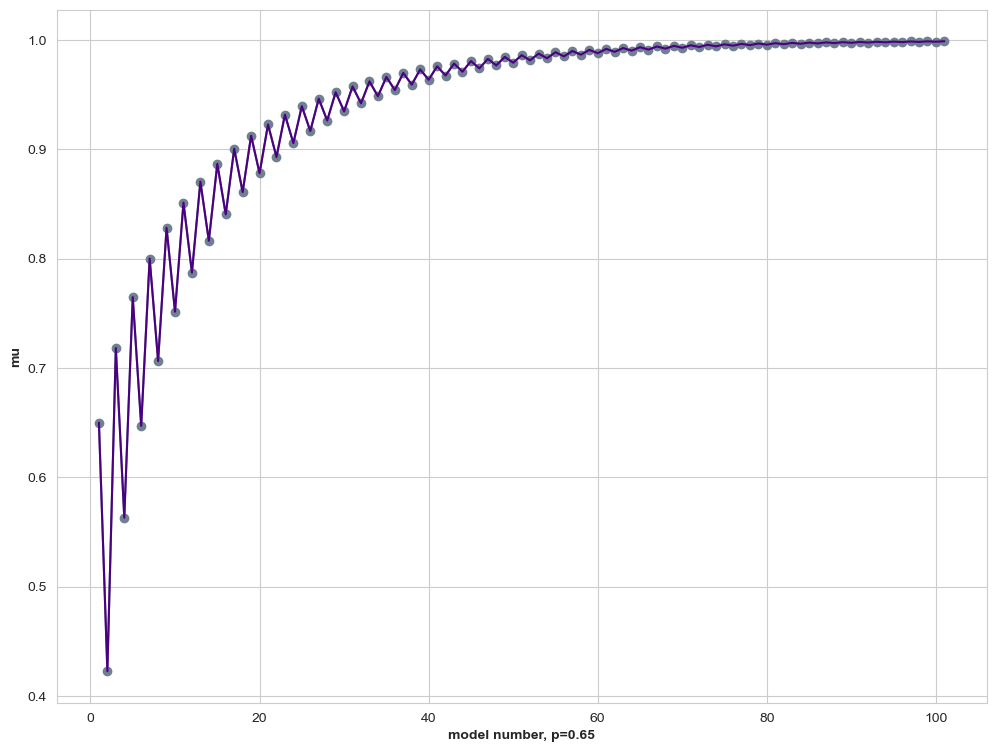

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

p = 0.65
mdls = np.arange(1, 102)
m = np.zeros([102])
for mdl in mdls:
    for i in np.arange(mdl // 2 + 1, mdl + 1):
        m[mdl] += (np.power((1 - p), (mdl - i)) * np.power(p, i) * math.factorial(mdl)) / (math.factorial(i) * math.factorial(mdl - i))

mdlp = pd.DataFrame({'mdl_n':mdls, "m": m[1:]})
plt.subplot(111)
plt.plot(mdlp.mdl_n, mdlp.m, marker='o', color="slategray")
plt.plot(mdlp.mdl_n, mdlp.m, color="indigo")
plt.xlabel("model number, p=0.65", weight='bold')
plt.ylabel("mu", weight='bold')
;
#mdlp.plot('mdl_n', 'm', kind='line');

In [9]:
mdlp[mdlp.m >= 0.95].iloc[[0]]

mdl_n         m
28     29  0.952363

Опишите ваши наблюдения:

* given 101 classificators while predicting the object class by majority vote rule the probability of predicting the class correctly is ~0.98 and more if each classificator correct prediction probability is 0.6 and more.
* in majority vote rule is applied it is batter to use the odd number of classificators (bcs if even number is used then random comes up and it lowers the correct classification probability especially if low number of classificators is used)
* if each classificator predicts the class correctly with probability 0.65, the overall correct classification probability is 0.95 and more if 29 and more(odd number) classificators is used.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for tree_num in range(self.n_estimators):
            np.random.seed(seed=self.random_state + tree_num)
            mx_ftrs = np.random.choice(X.shape[1], self.max_features, replace=False)           
            self.feat_ids_by_tree.append(mx_ftrs)
            psample = np.random.choice(X.shape[0], X.shape[0] // 2, replace=True) # let's say the pseudosample is half the size of X
            psample_X = X[np.ix_(psample, mx_ftrs)]
            psample_y = y[psample]

            mdl = DecisionTreeClassifier(max_depth=self.max_depth,
                                         max_features=self.max_features,
                                         random_state=self.random_state)
            mdl.fit(psample_X, psample_y)
            self.trees.append(mdl)
        return self

    def predict_proba(self, X):
        y_proba = []
        tree_num = 0
        for tree in self.trees:
            tree_y_proba = tree.predict_proba(X[:, self.feat_ids_by_tree[tree_num]])
            tree_num += 1
            y_proba.append(tree_y_proba)

        return np.array(y_proba).mean(axis=0)


    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

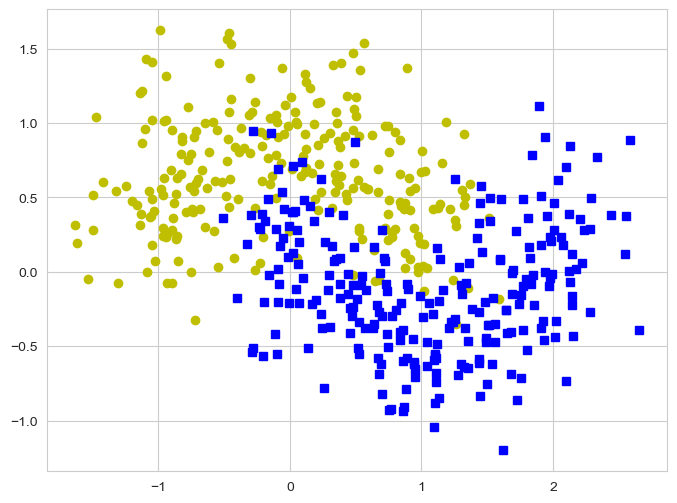

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

First I'll try it with some random parameters

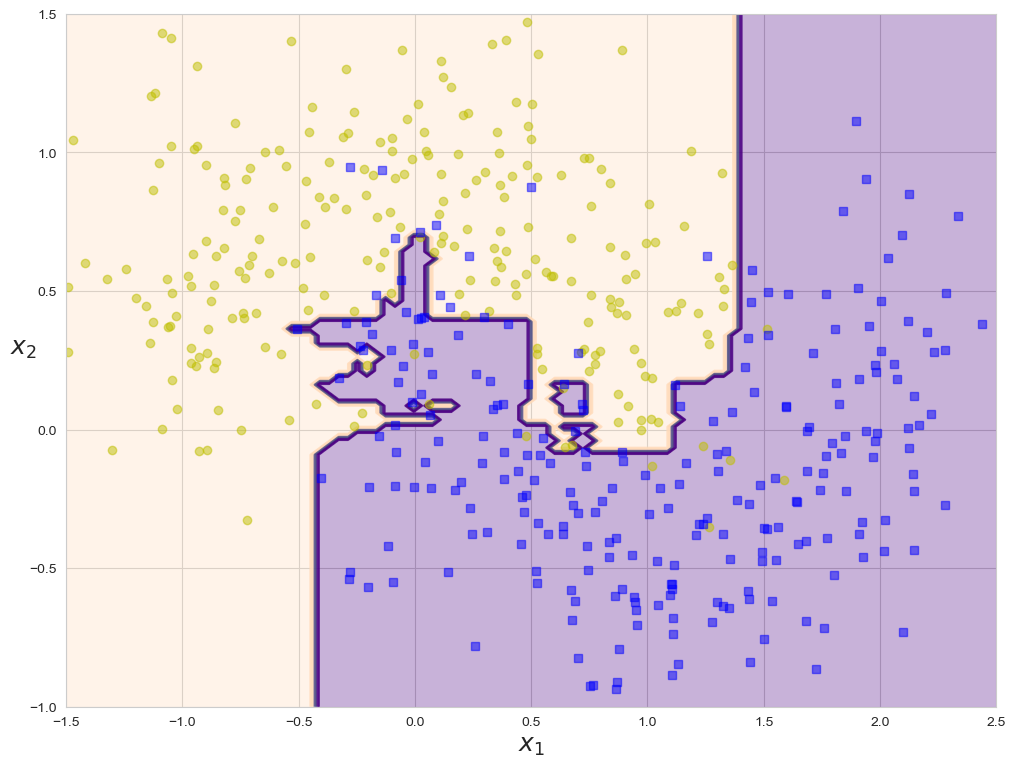

In [13]:
my_random_forest = RandomForestClassifierCustom(n_estimators=10, max_depth=10, max_features=2)
my_random_forest.fit(X, y)
plot_decision_boundary(my_random_forest, X, y)

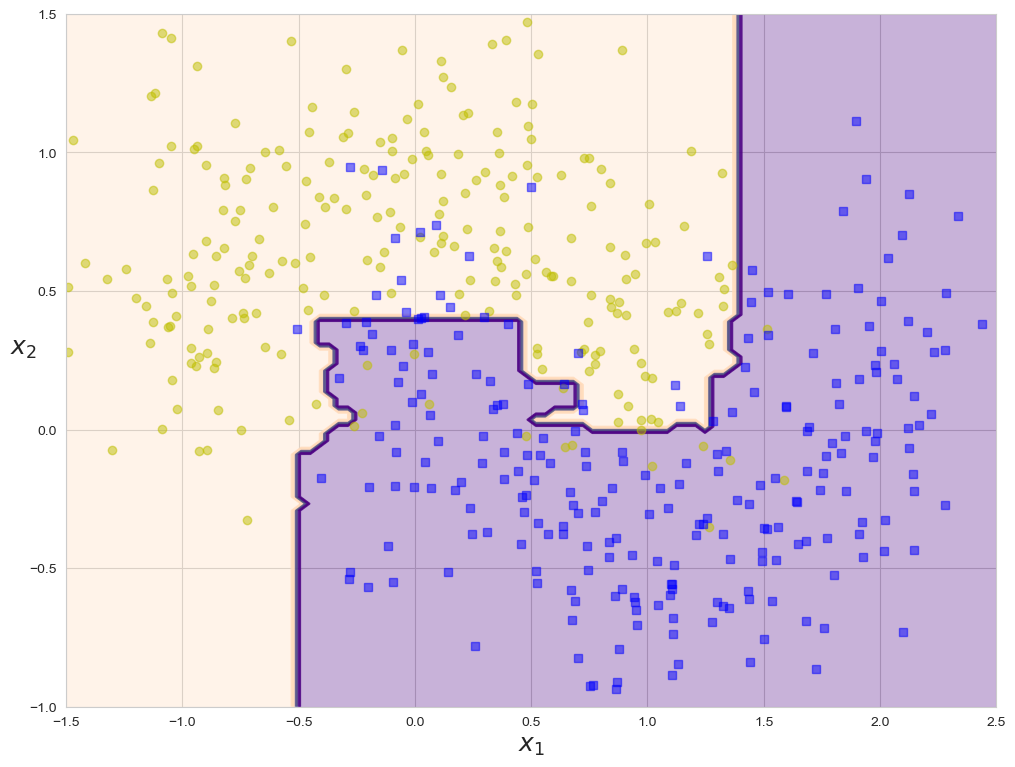

In [14]:
my_random_forest = RandomForestClassifierCustom(n_estimators=30, max_depth=5, max_features=2)
my_random_forest.fit(X, y)
plot_decision_boundary(my_random_forest, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)

In [16]:
n_est = range(1, 50)
m_depth = range(1, 20)
m_features = [1, 2]

best_n_est = None
mest_m_depth = None
best_m_features = None
best_accuracy_score = 0

for estimators_n in n_est:
    for depth_max in m_depth:
        for features_max in m_features:
            mdl = RandomForestClassifierCustom(n_estimators=estimators_n, max_depth=depth_max, max_features=features_max)
            mdl.fit(X_train, y_train)
            y_pred = mdl.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy_score:
                best_accuracy_score = accuracy
                best_n_est = estimators_n
                best_m_depth = depth_max
                best_m_features = features_max

print(f'Best model: n_estimators {best_n_est}, max_depth = {best_m_depth}, max_features = {best_m_features}, accuracy score = {best_accuracy_score}')

Best model: n_estimators 9, max_depth = 5, max_features = 2, accuracy score = 0.936


Best model

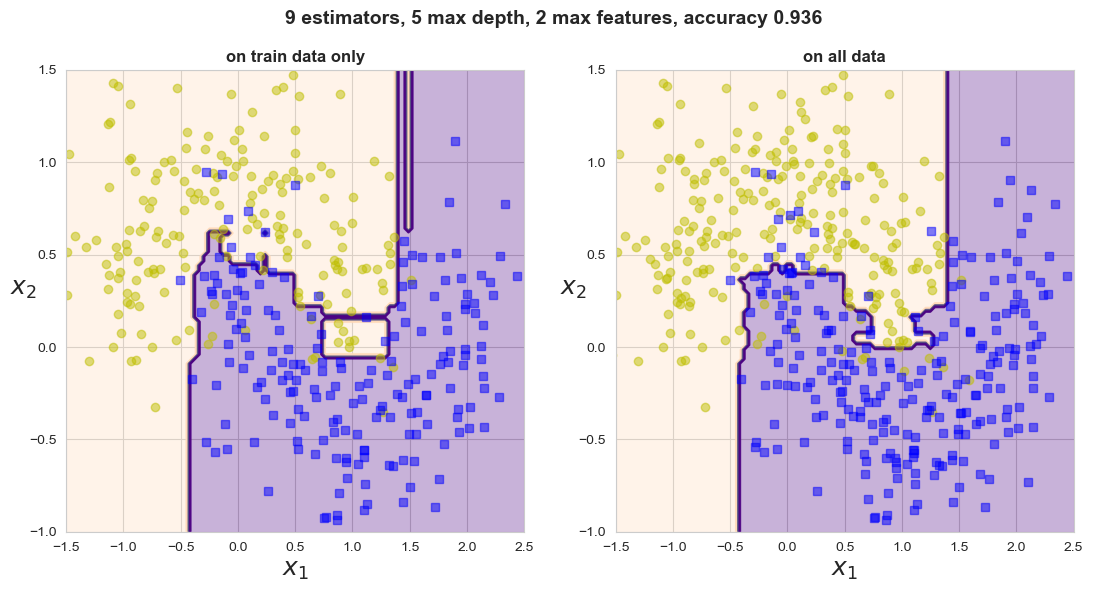

In [17]:
best_random_forest = RandomForestClassifierCustom(n_estimators=best_n_est, max_depth=best_m_depth, max_features=best_m_features)

plt.figure(figsize=(13, 6))
plt.suptitle(f"{best_n_est} estimators, {best_m_depth} max depth, {best_m_features} max features, accuracy {best_accuracy_score}",size=14, weight="bold")

plt.subplot(1, 2, 1)
best_random_forest.fit(X_train, y_train)
plt.title(f"on train data only", weight="bold")
plot_decision_boundary(best_random_forest, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("on all data", weight="bold")
best_random_forest.fit(X, y)
plot_decision_boundary(best_random_forest, X, y)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [18]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [19]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
len(X_train[0]) # 30 features in dataset

30

In [21]:
corr_lst = []
for ftrs in range(1, 31):
    mdl = RandomForestClassifier(max_features=ftrs)
    mdl.fit(X_train, y_train)
    corr_lst.append(base_model_pair_correlation(mdl, X_test))

''

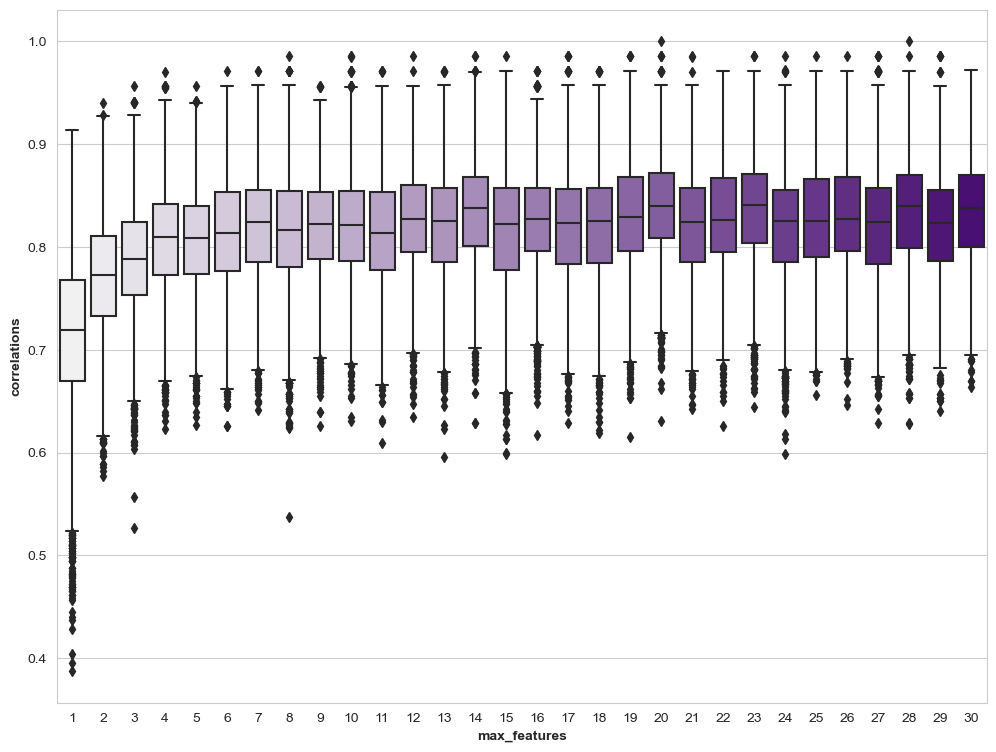

In [22]:
ax = sns.boxplot(corr_lst, palette="light:indigo")
ax.set_xticklabels([int(t.get_text()) + 1 for t in ax.get_xticklabels()])
plt.xlabel("max_features", weight="bold")
plt.ylabel("correlations", weight="bold")
;

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [23]:
corr_lst_d = []
for dpth in range(1, 20):
    mdl = RandomForestClassifier(max_depth=dpth)
    mdl.fit(X_train, y_train)
    corr_lst_d.append(base_model_pair_correlation(mdl, X_test))

''

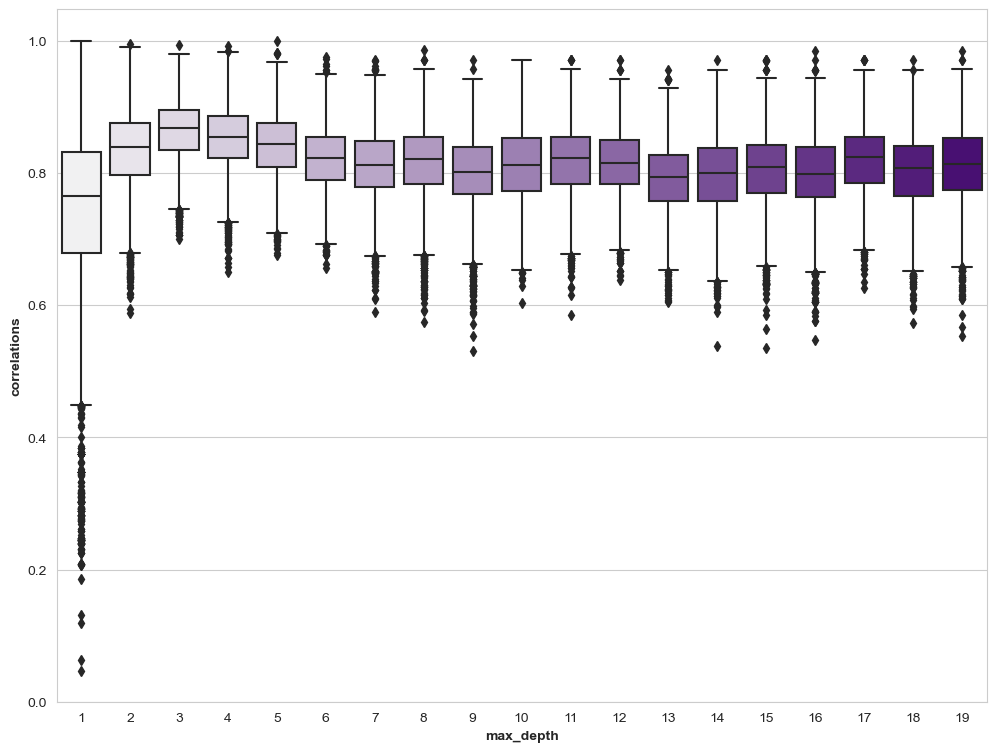

In [24]:
ax = sns.boxplot(corr_lst_d, palette="light:indigo")
ax.set_xticklabels([int(t.get_text()) + 1 for t in ax.get_xticklabels()])
plt.xlabel("max_depth", weight="bold")
plt.ylabel("correlations", weight="bold")
;

Опишите ваши наблюдения:

* correlations between model predictions increase if max_features increase in interval 1-6. more than 6 max_features do not impact correlactions a lot.
* model predictions correlations are highest if max_depth = 4, while increasing max_depth from 5 to 20, correlations slightly decrease. 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [3]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [4]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [6]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [11]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8426829268292683
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [7]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1.__str__, est2.__str__, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [9]:
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

In [10]:
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])

In [79]:
ens_search_df.pivot(index='classifier_1', columns='classifier_2', values='corr_score')

classifier_2                                        <method-wrapper '__str__' of RandomForestClassifier object at 0x7f76dc701d00>  \
classifier_1                                                                                                                        
<method-wrapper '__str__' of DecisionTreeClassi...                                           0.813489                               
<method-wrapper '__str__' of RandomForestClassi...                                                NaN                               
<method-wrapper '__str__' of ExtraTreesClassifi...                                                NaN                               
<method-wrapper '__str__' of KNeighborsClassifi...                                                NaN                               
<method-wrapper '__str__' of SVC object at 0x7f...                                                NaN                               
<method-wrapper '__str__' of SVC object at 0x7f...                                                NaN                               
<method-wrapper '__str__' of CatBoostClassifier...                                                NaN                               
<method-wrapper '__str__' of LGBMClassifier obj...                                                NaN                               
<method-wrapper '__str__' of LGBMClassifier obj...                                                NaN                               
<method-wrapper '__str__' of XGBClassifier obje...                                                NaN                               
<method-wrapper '__str__' of XGBRFClassifier ob...                                                NaN                               
<method-wrapper '__str__' of LogisticRegression...                                                NaN                               

classifier_2                                        <method-wrapper '__str__' of ExtraTreesClassifier object at 0x7f771da08fa0>  \
classifier_1                                                                                                                      
<method-wrapper '__str__' of DecisionTreeClassi...                                           0.774954                             
<method-wrapper '__str__' of RandomForestClassi...                                           0.921565                             
<method-wrapper '__str__' of ExtraTreesClassifi...                                                NaN                             
<method-wrapper '__str__' of KNeighborsClassifi...                                                NaN                             
<method-wrapper '__str__' of SVC object at 0x7f...                                                NaN                             
<method-wrapper '__str__' of SVC object at 0x7f...                                                NaN                             
<method-wrapper '__str__' of CatBoostClassifier...                                                NaN                             
<method-wrapper '__str__' of LGBMClassifier obj...                                                NaN                             
<method-wrapper '__str__' of LGBMClassifier obj...                                                NaN                             
<method-wrapper '__str__' of XGBClassifier obje...                                                NaN                             
<method-wrapper '__str__' of XGBRFClassifier ob...                                                NaN                             
<method-wrapper '__str__' of LogisticRegression...                                                NaN                             

classifier_2                                        <method-wrapper '__str__' of KNeighborsClassifier object at 0x7f76d29034c0>  \
classifier_1                                                                                                                      
<method-wrapper '__str__' of DecisionTre

In [82]:
ens_search_df.sort_values('corr_score')

classifier_1  \
41  <method-wrapper '__str__' of KNeighborsClassif...   
51  <method-wrapper '__str__' of SVC object at 0x7...   
53  <method-wrapper '__str__' of SVC object at 0x7...   
33  <method-wrapper '__str__' of KNeighborsClassif...   
40  <method-wrapper '__str__' of KNeighborsClassif...   
..                                                ...   
72  <method-wrapper '__str__' of XGBClassifier obj...   
48  <method-wrapper '__str__' of SVC object at 0x7...   
26  <method-wrapper '__str__' of ExtraTreesClassif...   
57  <method-wrapper '__str__' of CatBoostClassifie...   
64  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
41  <method-wrapper '__str__' of GaussianNB object...    0.231372  
51  <method-wrapper '__str__' of LGBMClassifier ob...    0.234962  
53  <method-wrapper '__str__' of XGBClassifier obj...    0.238971  
33  <method-wrapper '__str__' of SVC object at 0x7...    0.249799  
40  <method-wrapper '__str__' of LogisticRegressio...    0.269734  
..                                                ...         ...  
72  <method-wrapper '__str__' of XGBRFClassifier o...    0.947816  
48  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
26  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
57  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
64  <method-wrapper '__str__' of XGBClassifier obj...    0.963439  

[78 rows x 3 columns]

In [85]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("LGBM_RF", lgbm_rf), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8500429864957745


classifier_1  \
13  <method-wrapper '__str__' of RandomForestClass...   
39  <method-wrapper '__str__' of LGBMClassifier ob...   
9   <method-wrapper '__str__' of RandomForestClass...   
14  <method-wrapper '__str__' of RandomForestClass...   
33  <method-wrapper '__str__' of SVC object at 0x7...   

                                         classifier_2  corr_score  
13  <method-wrapper '__str__' of LGBMClassifier ob...    0.914669  
39  <method-wrapper '__str__' of XGBRFClassifier o...    0.916220  
9   <method-wrapper '__str__' of ExtraTreesClassif...    0.921565  
14  <method-wrapper '__str__' of XGBRFClassifier o...    0.933861  
33  <method-wrapper '__str__' of LogisticRegressio...    0.952143

In [86]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8441819224951755


classifier_1  \
27  <method-wrapper '__str__' of LogisticRegressio...   
9   <method-wrapper '__str__' of RandomForestClass...   
22  <method-wrapper '__str__' of LGBMClassifier ob...   
7   <method-wrapper '__str__' of RandomForestClass...   
10  <method-wrapper '__str__' of RandomForestClass...   

                                         classifier_2  corr_score  
27  <method-wrapper '__str__' of GaussianNB object...    0.892515  
9   <method-wrapper '__str__' of LGBMClassifier ob...    0.914669  
22  <method-wrapper '__str__' of XGBRFClassifier o...    0.916220  
7   <method-wrapper '__str__' of ExtraTreesClassif...    0.921565  
10  <method-wrapper '__str__' of XGBRFClassifier o...    0.933861

In [87]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc),
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr), ("NB", nb)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8540907687557889


classifier_1  \
2   <method-wrapper '__str__' of DecisionTreeClass...   
10  <method-wrapper '__str__' of ExtraTreesClassif...   
14  <method-wrapper '__str__' of LogisticRegressio...   
6   <method-wrapper '__str__' of RandomForestClass...   
5   <method-wrapper '__str__' of RandomForestClass...   

                                         classifier_2  corr_score  
2   <method-wrapper '__str__' of LGBMClassifier ob...    0.861266  
10  <method-wrapper '__str__' of LogisticRegressio...    0.869349  
14  <method-wrapper '__str__' of GaussianNB object...    0.892515  
6   <method-wrapper '__str__' of LGBMClassifier ob...    0.914669  
5   <method-wrapper '__str__' of ExtraTreesClassif...    0.921565

In [128]:
base_models = [("DT", dt), 
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.862026862026862


classifier_1  \
33  <method-wrapper '__str__' of XGBClassifier obj...   
20  <method-wrapper '__str__' of SVC object at 0x7...   
10  <method-wrapper '__str__' of ExtraTreesClassif...   
26  <method-wrapper '__str__' of CatBoostClassifie...   
30  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
33  <method-wrapper '__str__' of XGBRFClassifier o...    0.947816  
20  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
10  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
26  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
30  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [131]:
base_models = [("DT", dt), 
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8622968495399395


classifier_1  \
23  <method-wrapper '__str__' of CatBoostClassifie...   
17  <method-wrapper '__str__' of SVC object at 0x7...   
9   <method-wrapper '__str__' of ExtraTreesClassif...   
22  <method-wrapper '__str__' of CatBoostClassifie...   
25  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
23  <method-wrapper '__str__' of XGBClassifier obj...    0.934455  
17  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
9   <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
22  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
25  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [145]:
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8618863640214869


classifier_1  \
11  <method-wrapper '__str__' of RandomForestClass...   
25  <method-wrapper '__str__' of SVC object at 0x7...   
17  <method-wrapper '__str__' of ExtraTreesClassif...   
30  <method-wrapper '__str__' of CatBoostClassifie...   
33  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
11  <method-wrapper '__str__' of CatBoostClassifie...    0.945070  
25  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
17  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
30  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
33  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

let's make DT and RF better

In [146]:
max_depth_r = range(1, 20)
min_samples_leaf_r = range(1, 20)
min_samples_split_r = range(2, 20)

best_depth = None
best_min_samples_leaf = None
best_min_samples_split = None
best_f1 = 0

for d in max_depth_r:
    for sl in min_samples_leaf_r:
        for ss in min_samples_split_r:
            dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
            dt.fit(X_train, y_train)
            this_f1 = cross_val_score(dt, X_train, y_train, cv=3, scoring="f1")
            if this_f1.mean() > best_f1:
                best_depth = d
                best_min_samples_leaf = sl
                best_min_samples_split = ss
                best_f1 = this_f1.mean()
print(f'best depth {best_depth}, best min samples leaf {best_min_samples_leaf}, best min samples split {best_min_samples_split} best f1 {best_f1}')

best depth 1, best min samples leaf 1, best min samples split 2 best f1 0.797997226792219


In [157]:
n_est = range(1, 50)
m_depth = range(1, 20)
m_features = range(1, 10)

best_n_est = None
mest_m_depth = None
best_m_features = None
best_f1_score = 0

for estimators_n in n_est:
    for depth_max in m_depth:
        for features_max in m_features:
            mdl = RandomForestClassifier(n_estimators=estimators_n, max_depth=depth_max, max_features=features_max)
            mdl.fit(X_train, y_train)
            this_f1 = cross_val_score(mdl, X_train, y_train, cv=3, scoring="f1")
            if this_f1.mean() > best_f1_score:
                best_f1_score = this_f1.mean()
                best_n_est = estimators_n
                best_m_depth = depth_max
                best_m_features = features_max

print(f'Best model: n_estimators {best_n_est}, max_depth = {best_m_depth}, max_features = {best_m_features}, f1 score = {best_f1_score}')

Best model: n_estimators 25, max_depth = 19, max_features = 5, f1 score = 0.88369939707149


Set dt and rf with best hyperparameters

In [160]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=1, min_samples_leaf=1, min_samples_split=2)
rf = RandomForestClassifier(n_estimators=25, max_depth=19, max_features=5, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


In [161]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8408732490939368


classifier_1  \
72  <method-wrapper '__str__' of XGBClassifier obj...   
48  <method-wrapper '__str__' of SVC object at 0x7...   
26  <method-wrapper '__str__' of ExtraTreesClassif...   
57  <method-wrapper '__str__' of CatBoostClassifie...   
64  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
72  <method-wrapper '__str__' of XGBRFClassifier o...    0.947816  
48  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
26  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
57  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
64  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [165]:
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8429295261502139


classifier_1  \
31  <method-wrapper '__str__' of CatBoostClassifie...   
25  <method-wrapper '__str__' of SVC object at 0x7...   
17  <method-wrapper '__str__' of ExtraTreesClassif...   
30  <method-wrapper '__str__' of CatBoostClassifie...   
33  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
31  <method-wrapper '__str__' of XGBClassifier obj...    0.934455  
25  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
17  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
30  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
33  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [166]:
base_models = [("DT", dt),
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8431938431938434


classifier_1  \
23  <method-wrapper '__str__' of CatBoostClassifie...   
17  <method-wrapper '__str__' of SVC object at 0x7...   
9   <method-wrapper '__str__' of ExtraTreesClassif...   
22  <method-wrapper '__str__' of CatBoostClassifie...   
25  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
23  <method-wrapper '__str__' of XGBClassifier obj...    0.934455  
17  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
9   <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
22  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
25  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [170]:
base_models = [("DT", dt), ("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf),
               ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8402858185990715


classifier_1  \
30  <method-wrapper '__str__' of CatBoostClassifie...   
35  <method-wrapper '__str__' of LogisticRegressio...   
12  <method-wrapper '__str__' of RandomForestClass...   
11  <method-wrapper '__str__' of RandomForestClass...   
24  <method-wrapper '__str__' of SVC object at 0x7...   

                                         classifier_2  corr_score  
30  <method-wrapper '__str__' of LGBMClassifier ob...    0.882031  
35  <method-wrapper '__str__' of GaussianNB object...    0.892515  
12  <method-wrapper '__str__' of LGBMClassifier ob...    0.901627  
11  <method-wrapper '__str__' of CatBoostClassifie...    0.914540  
24  <method-wrapper '__str__' of LogisticRegressio...    0.952143

ok, the idea with best dt hyperparameters failed, back to original

In [177]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
base_models = [("DT", dt), 
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8622968495399395


classifier_1  \
23  <method-wrapper '__str__' of CatBoostClassifie...   
17  <method-wrapper '__str__' of SVC object at 0x7...   
9   <method-wrapper '__str__' of ExtraTreesClassif...   
22  <method-wrapper '__str__' of CatBoostClassifie...   
25  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
23  <method-wrapper '__str__' of XGBClassifier obj...    0.934455  
17  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
9   <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
22  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
25  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [192]:
base_models = [("DT", dt), 
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr)]
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.853160683723441


classifier_1  \
63  <method-wrapper '__str__' of XGBClassifier obj...   
44  <method-wrapper '__str__' of SVC object at 0x7...   
24  <method-wrapper '__str__' of ExtraTreesClassif...   
51  <method-wrapper '__str__' of CatBoostClassifie...   
57  <method-wrapper '__str__' of LGBMClassifier ob...   

                                         classifier_2  corr_score  
63  <method-wrapper '__str__' of XGBRFClassifier o...    0.947816  
44  <method-wrapper '__str__' of LogisticRegressio...    0.952143  
24  <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
51  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278  
57  <method-wrapper '__str__' of XGBClassifier obj...    0.963439

In [12]:
sample_list = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]

list_combinations = list()

for n in range(2, len(sample_list) + 1):
    list_combinations.extend(list(combinations(sample_list, n)))

features_comb_res = list()

for features_comb in list_combinations:
    print([features_comb[i][0] for i in range(len(features_comb))])
    voting_soft = VotingClassifier(estimators=features_comb, voting='soft')
    voting_soft.fit(X_train, y_train)
    ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
    ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
    scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
    features_comb_res.append([[features_comb[i][0] for i in range(len(features_comb))], scores.mean()])

['DT', 'RF']
VotingClassifier: 0.8113863399842575
['DT', 'ETC']
VotingClassifier: 0.8097494553376906
['DT', 'KNN']
VotingClassifier: 0.7540859661761176
['DT', 'SVC_LIN']
VotingClassifier: 0.8251166829480082
['DT', 'SVC_RBF']
VotingClassifier: 0.7896153846153845
['DT', 'CAT']
VotingClassifier: 0.8202408757964313
['DT', 'LGBM']
VotingClassifier: 0.8172132976349843
['DT', 'LGBM_RF']
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsam

In [15]:
ensembles_f1_df = pd.DataFrame(features_comb_res, columns=["Classifiers_combination", "f1_score"])

In [17]:
ensembles_f1_df.to_csv("../data/ensembles_f1.tsv", sep="\t")

In [21]:
ensembles_f1_df.sort_values(by="f1_score").tail(10)

Classifiers_combination  f1_score
2585           [DT, RF, ETC, SVC_LIN, LGBM_RF, XGB, LR]  0.866787
2587            [DT, RF, ETC, SVC_LIN, XGB, XGB_RF, LR]  0.866787
1609                   [DT, RF, ETC, SVC_LIN, CAT, XGB]  0.866787
3388       [DT, RF, ETC, SVC_LIN, CAT, XGB, XGB_RF, LR]  0.866787
3385  [DT, RF, ETC, SVC_LIN, CAT, LGBM_RF, XGB, XGB_RF]  0.866787
640                         [ETC, CAT, LGBM_RF, XGB_RF]  0.868773
1397               [ETC, SVC_LIN, CAT, LGBM_RF, XGB_RF]  0.868773
606                        [ETC, SVC_LIN, CAT, LGBM_RF]  0.868773
55                                            [CAT, LR]  0.869454
968                            [DT, ETC, CAT, LGBM, LR]  0.870421

Deletewhats next

In [5]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

In [ ]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [10]:
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LR", lr)]

In [12]:
voting_soft = VotingClassifier(estimators=base_models, voting='hard')
voting_soft.fit(X_train, y_train)
ens_search = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
ens_search_df = pd.DataFrame(ens_search, columns=['classifier_1', 'classifier_2', 'corr_score'])
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")
ens_search_df.sort_values('corr_score').tail()

VotingClassifier: 0.8468724988135965


classifier_1  \
7   <method-wrapper '__str__' of RandomForestClass...   
5   <method-wrapper '__str__' of RandomForestClass...   
6   <method-wrapper '__str__' of RandomForestClass...   
9   <method-wrapper '__str__' of ExtraTreesClassif...   
12  <method-wrapper '__str__' of CatBoostClassifie...   

                                         classifier_2  corr_score  
7   <method-wrapper '__str__' of LGBMClassifier ob...    0.914687  
5   <method-wrapper '__str__' of ExtraTreesClassif...    0.921565  
6   <method-wrapper '__str__' of CatBoostClassifie...    0.945070  
9   <method-wrapper '__str__' of CatBoostClassifie...    0.952720  
12  <method-wrapper '__str__' of LGBMClassifier ob...    0.955278

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [157]:
data = pd.read_csv("../data/churn.csv")
print(data.shape)
data.head()

(3333, 21)


State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [159]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

Need to fix some of the values in the dataset

In [160]:
data.replace({"True.": 1, "False.": 0, "yes": 1, "no": 0}, inplace=True)

In [161]:
data = data.drop(["State", "Phone"], axis=1)\
    .rename(columns={"Churn?": "Churn"}) # drop non-numerical and non-informative features

In [162]:
data

Account Length  Area Code  Int'l Plan  VMail Plan  VMail Message  \
0                128        415           0           1             25   
1                107        415           0           1             26   
2                137        415           0           0              0   
3                 84        408           1           0              0   
4                 75        415           1           0              0   
...              ...        ...         ...         ...            ...   
3328             192        415           0           1             36   
3329              68        415           0           0              0   
3330              28        510           0           0              0   
3331             184        510           1           0              0   
3332              74        415           0           1             25   

      Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  \
0        265.1        110       45.07     197.4         99       16.78   
1        161.6        123       27.47     195.5        103       16.62   
2        243.4        114       41.38     121.2        110       10.30   
3        299.4         71       50.90      61.9         88        5.26   
4        166.7        113       28.34     148.3        122       12.61   
...        ...        ...         ...       ...        ...         ...   
3328     156.2         77       26.55     215.5        126       18.32   
3329     231.1         57       39.29     153.4         55       13.04   
3330     180.8        109       30.74     288.8         58       24.55   
3331     213.8        105       36.35     159.6         84       13.57   
3332     234.4        113       39.85     265.9         82       22.60   

      Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0          244.7           91         11.01       10.0           3   
1          254.4          103         11.45       13.7           3   
2          162.6          104          7.32       12.2           5   
3          196.9           89          8.86        6.6           7   
4          186.9          121          8.41       10.1           3   
...          ...          ...           ...        ...         ...   
3328       279.1           83         12.56        9.9           6   
3329       191.3          123          8.61        9.6           4   
3330       191.9           91          8.64       14.1           6   
3331       139.2          137          6.26        5.0          10   
3332       241.4           77         10.86       13.7           4   

      Intl Charge  CustServ Calls  Churn  
0            2.70               1      0  
1            3.70               1      0  
2            3.29               0      0  
3            1.78               2      0  
4            2.73               3      0  
...           ...             ...    ...  
3328         2.67               2      0  
3329         2.59               3      0  
3330         3.81               2      0  
3331         1.35               2      0  
3332         3.70               0      0  

[3333 rows x 19 columns]

''

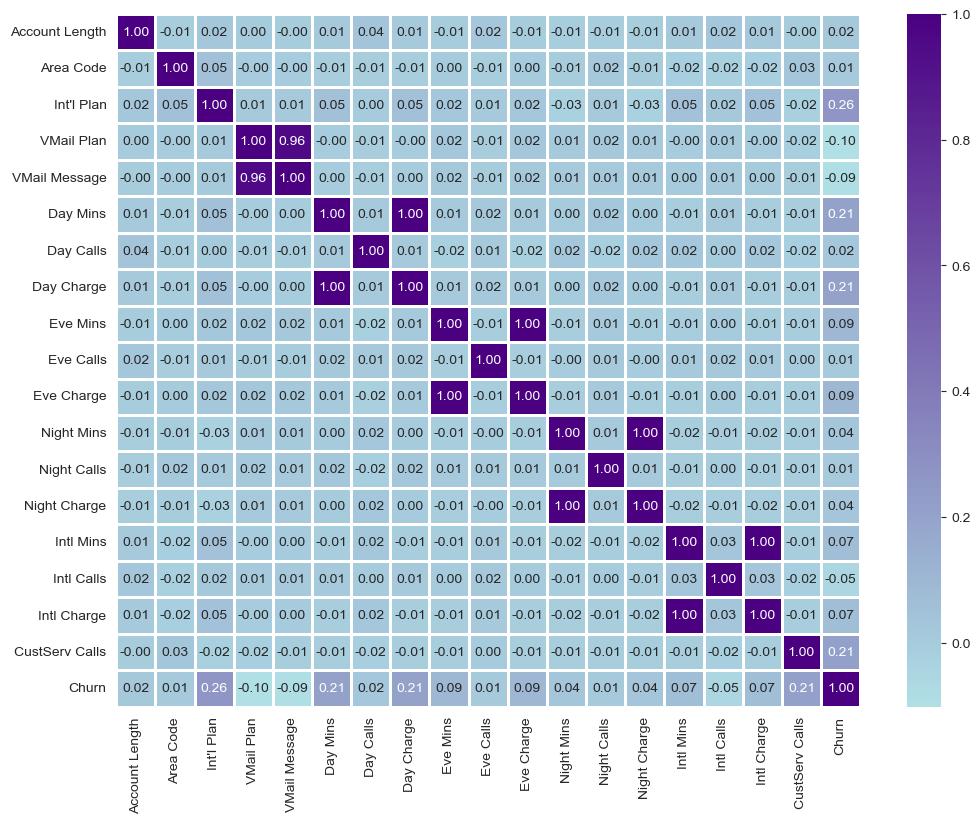

In [189]:
sns.heatmap(data.corr(), linewidths=1, annot=True, fmt=".2f", cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))
;

In [76]:
data.columns

Index(['Account Length', 'Area Code', 'Int'l Plan', 'VMail Plan',
       'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins',
       'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge',
       'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn'],
      dtype='object')

In [78]:
data = data.drop(["VMail Plan", "Day Mins", "Eve Mins", "Night Mins", "Intl Mins"], axis=1)

In [79]:
data.Churn.value_counts() 

0    2850
1     483
Name: Churn, dtype: int64

need to fix class disbalance => resampling after train\test split

In [80]:
X, y = data.drop("Churn", axis = 1), data.Churn
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)
train = pd.concat([X_train, y_train], axis=1)
train_res = pd.concat([resample(train[train.Churn == True], 
         random_state=SEED, 
         n_samples=train.Churn.value_counts()[0], 
         replace=True), train[train.Churn == False]], axis=0)
X_train, y_train = train_res.drop("Churn", axis = 1), train_res.Churn

In [81]:
train_res.Churn.value_counts()

1    2133
0    2133
Name: Churn, dtype: int64

In [82]:
norm = StandardScaler()
norm.fit(X_train)
X_train, X_test = norm.transform(X_train), norm.transform(X_test)

RandomForest LGBMClassifier

In [83]:
mdl = lightgbm.LGBMClassifier(boosting_type="rf", n_estimators=10,
                         bagging_freq=1, bagging_fraction=0.9, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.9124700239808153

In [84]:
mdl = lightgbm.LGBMClassifier(boosting_type="rf", n_estimators=30,
                         bagging_freq=1, bagging_fraction=0.9, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.9232613908872902

In [102]:
mdl = lightgbm.LGBMClassifier(boosting_type="rf", 
                         n_estimators=10,
                         bagging_freq=5, 
                         bagging_fraction=0.9, 
                         random_state=SEED)
mdl.fit(X_train, y_train)
params = [{
    'n_estimators': np.arange(5, 50, 5),
    'bagging_freq': np.arange(5, 50, 5),
    'bagging_fraction': np.arange(0, 1, 0.1)
    }]
gs_mdl = GridSearchCV(mdl, 
                      param_grid=params, 
                      scoring='accuracy', 
                      cv=5)
gs_mdl.fit(X_train, y_train)
y_pred = gs_mdl.predict(X_test)
print(accuracy_score(y_test, y_pred))
gs_mdl.best_params_

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-pack

[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagg

{'bagging_fraction': 0.9, 'bagging_freq': 10, 'n_estimators': 45}

In [105]:
mdl = lightgbm.LGBMClassifier(boosting_type="rf", n_estimators=10,
                         bagging_freq=5, bagging_fraction=0.9, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.9256594724220624

In [187]:
best_mdl = lightgbm.LGBMClassifier(boosting_type="rf", n_estimators=10,
                         bagging_freq=5, bagging_fraction=0.9, random_state=SEED)
best_mdl.fit(X_train, y_train)
y_pred_train = best_mdl.predict(X_train)
y_pred_test = best_mdl.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.9436450839328537

''

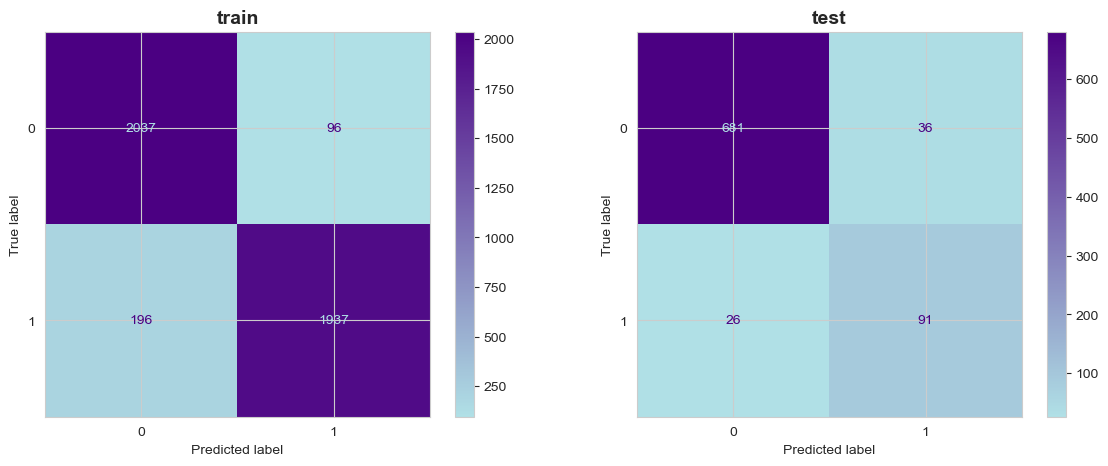

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

cm_train = confusion_matrix(y_train, y_pred_train, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[0], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))

cm_test = confusion_matrix(y_test, y_pred_test, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[1], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))
;

''

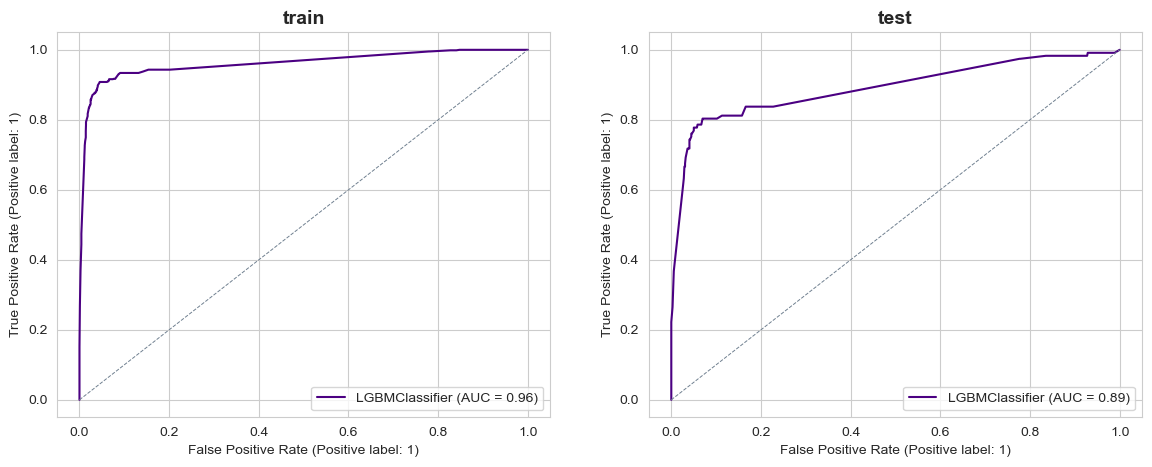

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

RocCurveDisplay.from_estimator(best_mdl, X_train, y_train, ax=ax[0], color='indigo')
ax[0].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)

RocCurveDisplay.from_estimator(best_mdl, X_test, y_test, ax=ax[1], color='indigo')
ax[1].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)
;

XGBRFClassifier

In [87]:
mdl = xgboost.XGBRFClassifier(n_estimators=100, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9304556354916067

In [97]:
mdl = xgboost.XGBRFClassifier(n_estimators=100, max_depth=20, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9424460431654677

In [99]:
mdl = XGBRFClassifier(random_state=SEED)
mdl.fit(X_train, y_train)
params = [{
    'max_depth': np.arange(1, 30, 5),
    'n_estimators': np.arange(50, 500, 10),
    }]
gs_mdl = GridSearchCV(mdl, 
                      param_grid=params, 
                      scoring='accuracy', 
                      cv=5)
gs_mdl.fit(X_train, y_train)
y_pred = gs_mdl.predict(X_test)
print(accuracy_score(y_test, y_pred))
gs_mdl.best_params_

0.9436450839328537


{'max_depth': 16, 'n_estimators': 240}

Now run the XGBRFClassifier with best parameters to check the run time

In [129]:
mdl = xgboost.XGBRFClassifier(n_estimators=240, max_depth=16, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436450839328537

Catboost

In [112]:
mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436450839328537

In [115]:
mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED)
params = [{
    'max_depth': np.arange(1, 30, 10),
    'n_estimators': np.arange(50, 500, 100),
    }]
gs_mdl = GridSearchCV(mdl, 
                      param_grid=params, 
                      scoring='accuracy', 
                      cv=5)
gs_mdl.fit(X_train, y_train)
y_pred = gs_mdl.predict(X_test)
print(accuracy_score(y_test, y_pred))
gs_mdl.best_params_

0.9436450839328537


{'max_depth': 11, 'n_estimators': 350}

Run the model with best parameters to check the run time

In [126]:
mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED,
                                  n_estimators=350, max_depth=11)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436450839328537

In [185]:
best_mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED,
                                  n_estimators=350, max_depth=11)
best_mdl.fit(X_train, y_train)
y_pred_train = best_mdl.predict(X_train)
y_pred_test = best_mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436450839328537

''

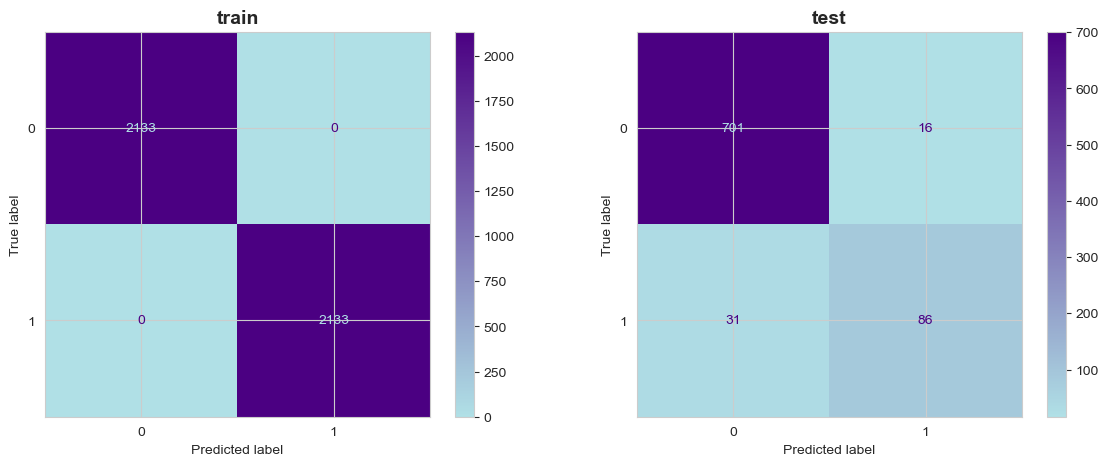

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

cm_train = confusion_matrix(y_train, y_pred_train, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[0], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))

cm_test = confusion_matrix(y_test, y_pred_test, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[1], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))
;

''

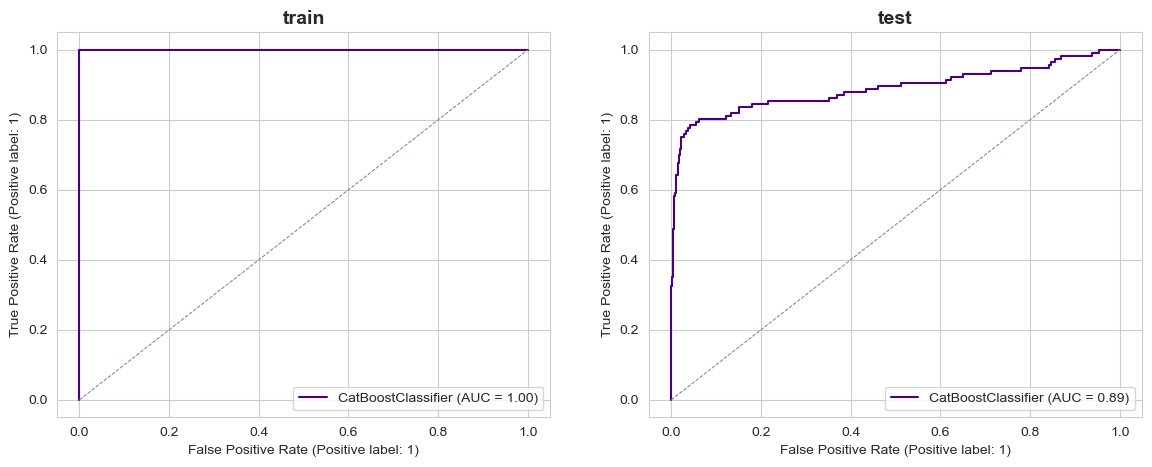

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

RocCurveDisplay.from_estimator(best_mdl, X_train, y_train, ax=ax[0], color='indigo')
ax[0].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)

RocCurveDisplay.from_estimator(best_mdl, X_test, y_test, ax=ax[1], color='indigo')
ax[1].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)
;

The best accuracy 0.944 was obtained either with CatBoostClassifier with 350 estimators and max depth 11 or with XGBRFClassifier with 240 estimators and max depth 16.
So, I propose XGBRClassifier as the optimal model among these two because it runs faster and uses less estimator number.

In [176]:
best_mdl = xgboost.XGBRFClassifier(n_estimators=240, max_depth=16, random_state=SEED)
best_mdl.fit(X_train, y_train)
y_pred_train = best_mdl.predict(X_train)
y_pred_test = best_mdl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9436450839328537

''

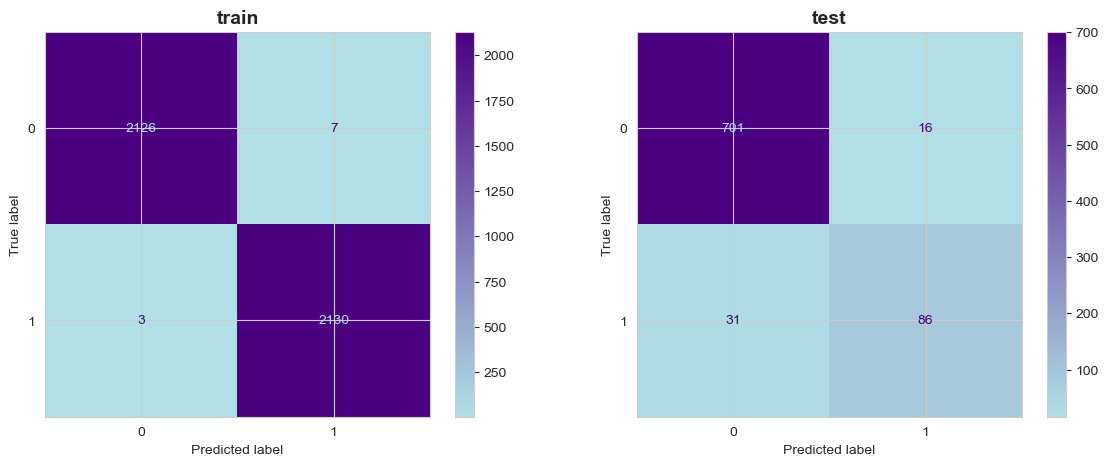

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

cm_train = confusion_matrix(y_train, y_pred_train, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[0], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))

cm_test = confusion_matrix(y_test, y_pred_test, labels=best_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=best_mdl.classes_)
disp.plot(ax=ax[1], cmap=sns.color_palette("blend:powderblue,indigo", as_cmap=True))
;

''

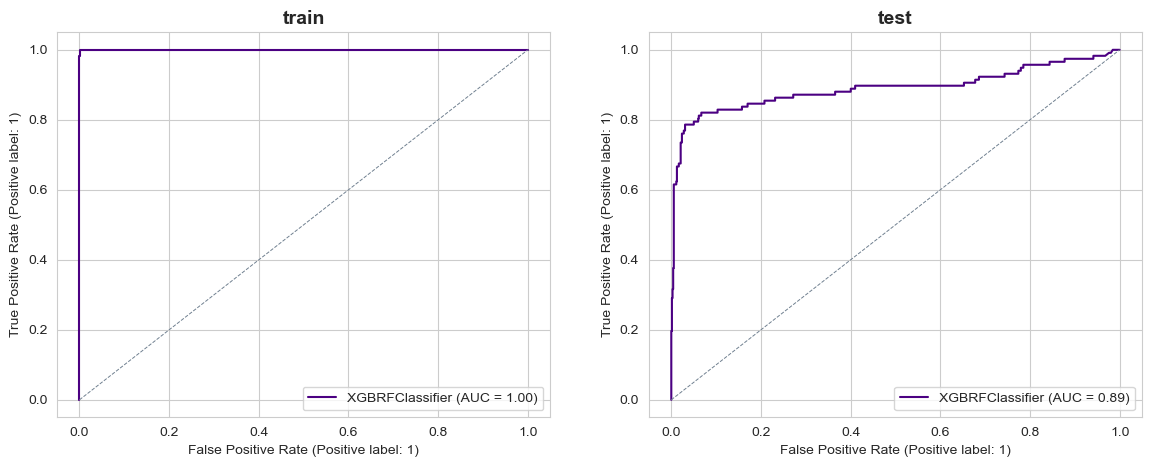

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

RocCurveDisplay.from_estimator(best_mdl, X_train, y_train, ax=ax[0], color='indigo')
ax[0].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)

RocCurveDisplay.from_estimator(best_mdl, X_test, y_test, ax=ax[1], color='indigo')
ax[1].plot([0, 1], linestyle='--', color='slategray', linewidth=0.7)
;

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [190]:
from IPython.display import Image

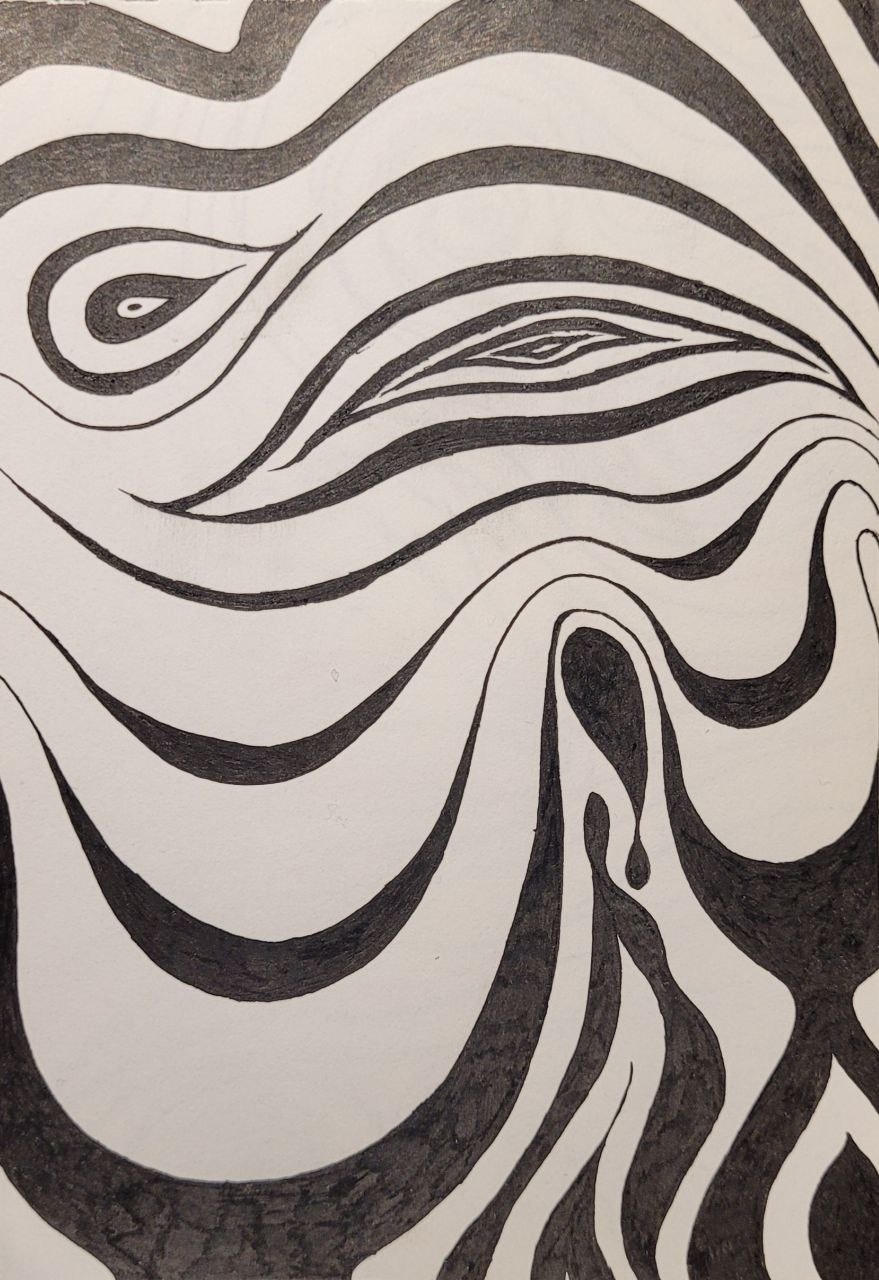

In [192]:
Image("dslv.jpg")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**